In [7]:
import pandas as pd
import eeg
from eeg import unix_to_localdate, unix_to_period
import datetime
import scipy.stats
import scipy.fftpack
import numpy as np
import matplotlib.pyplot as plt


files = eeg.extractBundledEEG("../../scripts/data/")
files.addMeta("../../scripts/data/eeg-restingstate/events.csv","timeofday")
files.prune()
# files.mergeTagsWithRegex("[cC]lose","Eyes Closed")
files.categories
dataAgg = dict()

bands_ordered = ["delta", "theta", "alpha", "beta", "gamma"]

class analysisEngine():
    def __init__(self,fileBundles:dict):
        """
        Generates basic analytics for recording groups
        
        fileBundles: {recordingsTagName:[set of recordingIds], tagName: ....} 
        
        """
        self.fileBundles = fileBundles
        self.fileBundleSummeries = {x:[] for x in self.fileBundles}

        for x in self.fileBundles:
            sum = 0
            for y in self.fileBundles[x]:
                self.fileBundleSummeries[x].append(eeg.load_session_summery(self.fileBundles[x][y],qualityCutoffFilter=.95,epochSize=15,returnEpoched=True,debug=False))
                sum += len(self.fileBundleSummeries[x][-1])
            print(f"{x} {len(self.fileBundles[x])} Recording Sessions Found, {sum} Epochs Extracted")

    def distributionVetting(self):
        self.accumulatedPowerBands = {x:dict() for x in self.fileBundles}
        for x in self.fileBundles: # Basic sanity checks of distributions
            for y in self.fileBundleSummeries[x]:
                for epoch in y:
                    for band in y[epoch]["avg_power_by_band"]:
                        if band not in self.accumulatedPowerBands [x]: self.accumulatedPowerBands [x][band] = []
                        self.accumulatedPowerBands [x][band].append(y[epoch]["avg_power_by_band"][band])

            count = 0
            for band in self.accumulatedPowerBands [x]:
                count+=1
                plt.subplot(5, 1, count)
                plt.hist(self.accumulatedPowerBands [x][band],bins=160)
                plt.title(f'{x}:{band} Epoch Averages')

                plt.xlabel('uV')
                plt.ylabel('Count')
                plt.grid(True)
                plt.show()

    def basicComparisons(self):
        accumatedPowerBandStats = {x:dict() for x in self.fileBundles}
        accumatedPowerBandErrors = {x:dict() for x in self.fileBundles}

        for x in self.accumulatedPowerBands: # avgs with error bars
            for band in self.accumulatedPowerBands[x]:
                accumatedPowerBandStats[x][band] = np.nanmean(np.array(self.accumulatedPowerBands[x][band]))
                # print(np.array(accumulatedPowerBands[x][band]))
                accumatedPowerBandErrors[x][band] = np.nanstd(np.array(self.accumulatedPowerBands[x][band])) # hilarous error bars on everything scaled to make visable
            
            
            
        fig, ax = plt.subplots()
        bar_width = .3
        currentBarDist = bar_width
        figs = {x:0 for x in self.fileBundles}
        index = np.arange(5)
        for x in accumatedPowerBandStats:
            print(x,accumatedPowerBandStats[x])
            ax.bar(index+currentBarDist,list(accumatedPowerBandStats[x].values()), bar_width,
                        label=x,yerr=list(accumatedPowerBandErrors[x].values()))
            currentBarDist+=bar_width

        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(accumatedPowerBandStats[x].keys())
        ax.set_xlabel('Band')
        ax.set_ylabel('Average uV')
        ax.set_title('Average uV by Band')
        ax.legend()

        plt.show()

analysis = analysisEngine({"morning":files.extractByTags("morning"),"evening":files.extractByTags("evening")})

1674926196 Meta available but no associated recordings
morning 13 Recording Sessions Found, 352 Epochs Extracted
evening 12 Recording Sessions Found, 396 Epochs Extracted


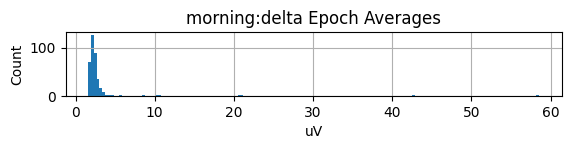

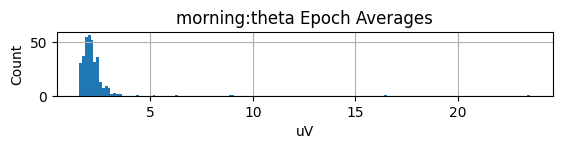

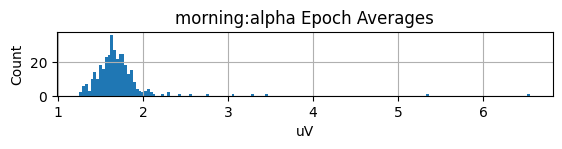

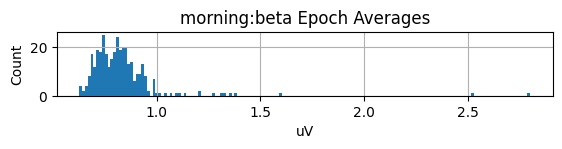

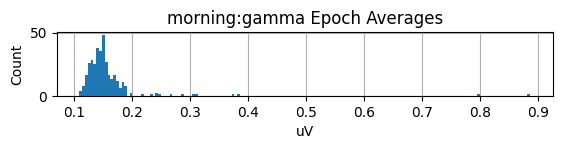

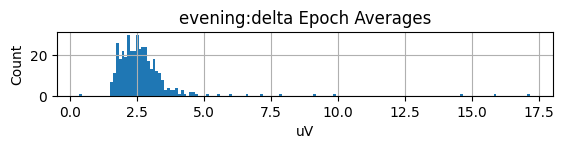

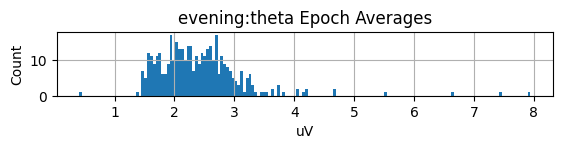

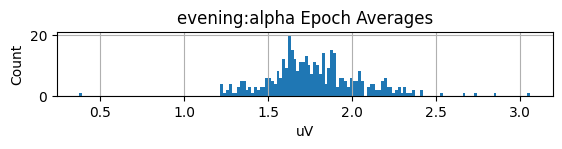

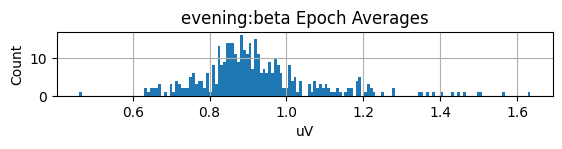

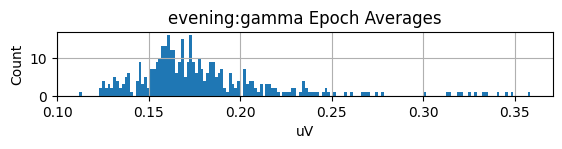

In [8]:
analysis.distributionVetting()

morning {'delta': 2.546016387806143, 'theta': 2.246160591799917, 'alpha': 1.69989888986002, 'beta': 0.8320760081202644, 'gamma': 0.15441380780121008}
evening {'delta': 2.817455931639661, 'theta': 2.4474306186371693, 'alpha': 1.79233591372596, 'beta': 0.9363778527765223, 'gamma': 0.18246877665754654}


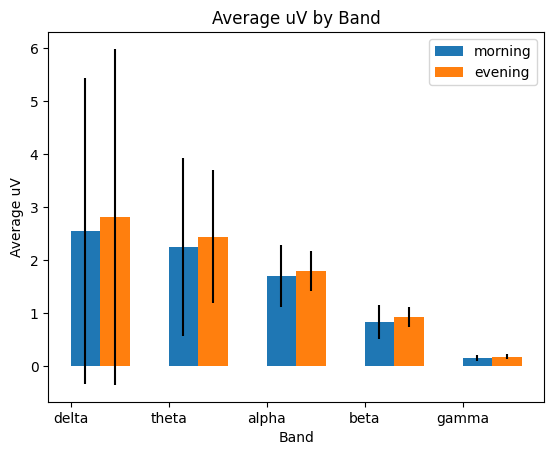

In [6]:
analysis.basicComparisons()

In [90]:

def load_session_epochs(files: dict, _on: set, qualityCutoffFilter: int = 0, epochSize: int = -1):
    """
    Takes a session of EEG data, computes some metrics, and returns them.
    qualityCutoffFilter: percentage of time electrode data is marked as "good" or "great" required for it to be included in output and analyticsl, 0 capture everything
    filterSampleWindow: window size to sample filters 

    Potential metrics:
     - average power by band
     - average power by channel
     - relative power by band
     - average focus/calm score
    """
    # Best channels are usually: CP3, CP4, PO3, PO4

    # NOTE: unixTimestamps are int/seconds but samples more often than 1Hz,
    #       so several rows per timestamp and missing sub-second resolution.
    df_sigQ = pd.read_json(files["signalQuality"])
    df_sigQ.set_index("unixTimestamp", inplace=True,drop=False)
    df_sigQ.index =  pd.to_datetime(df_sigQ.index, unit="s")

    print(df_sigQ.index[df_sigQ.shape[0]-9]-df_sigQ.index[0])


    _on.append("powerByBand")
    _on = set(_on)
    on = dict()
    for x in _on:
        if str(files[x]).endswith(".csv"):
            on[x] = pd.read_csv(files[x])
        else:
            on[x] = pd.read_json(files[x])

    for x in on:
        on[x].set_index("unixTimestamp", inplace=True)
        try:
            on[x].index =  pd.to_datetime(on[x].index, unit="s")
        except:
            on[x].index =  pd.to_datetime(on[x].index, unit="ms")
        on[x]["epoch"] = pd.NA

    if epochSize == -1: epochSize = (df_sigQ.index[df_sigQ.shape[0]-1]-df_sigQ.index[0]).seconds

    channels, bands = zip(*[c.split("_") for c in on["powerByBand"].columns[1:-1]])
    channels, bands = list(set(channels)), list(set(bands))


    onChan = {}
    for df in on:
        onChan[df] = {x: [y for y in on[df].columns if x in y] for x in channels}

    validEpochs:dict(list()) = {}
    invalidEpochs:dict(list()) = {}

    removedChannels = []
    epochSize = datetime.timedelta(seconds=epochSize)

    oldTime = df_sigQ.index[0]
    newTime = df_sigQ.index[0] + epochSize

    endTime = df_sigQ.index[df_sigQ.shape[0]-1]

    if(newTime>endTime): newTime = endTime
    finalLoop = False
    # print(oldTime,newTime, df_pbb.shape[0],df_sigQ.shape[0])
    qualitySamplesMissing = 0
    while(endTime>=newTime):
        sigSamp = df_sigQ[(df_sigQ.index < newTime) & (df_sigQ.index >= oldTime)]
        if not sigSamp.empty:
            for channel in channels:
                col = channel + "_status"
                channel_states = sigSamp[col].value_counts()
                no_of_okay_samples = 0
                if 'good' in channel_states:
                    no_of_okay_samples += channel_states['good']
                if 'great' in channel_states:
                    no_of_okay_samples += channel_states['great']

                percentage_good = no_of_okay_samples / sigSamp.shape[0]
                timeunix = int(datetime.datetime.timestamp(oldTime)*1000)
                if percentage_good>=qualityCutoffFilter: 
                    if timeunix not in validEpochs: validEpochs[timeunix] = (oldTime,[])
                    validEpochs[timeunix][1].append(channel) 
                else:
                    if timeunix not in invalidEpochs: invalidEpochs[timeunix] = (oldTime,[])
                    invalidEpochs[timeunix][1].append(channel) 

        if((newTime+epochSize)>endTime and not finalLoop): 
            oldTime = newTime
            newTime = endTime
            finalLoop = True
        else:
            oldTime = newTime
            newTime = newTime + epochSize
    
    # epochesReturn = {}
    print(invalidEpochs)
    for epoch in invalidEpochs:
        oldTime = invalidEpochs[epoch][0]
        newTime = invalidEpochs[epoch][0] + epochSize
        for x in on:
            cols = []
            for z in [onChan[x][y] for y in invalidEpochs[epoch][1]]:
                for y in z:
                    cols.append(y)
            print(cols)
            on[x].loc[((on[x].index < newTime) & (on[x].index >= oldTime)),cols] = pd.NA

    epochCount = 0
    for epoch in validEpochs:
        oldTime = validEpochs[epoch][0]
        newTime = validEpochs[epoch][0] + epochSize
        for x in on:
           on[x].loc[(on[x].index < newTime) & (on[x].index >= oldTime),"epoch"] = epochCount
           epochCount+=1
    return on


    
    # print(df_pbb["epoch_PO3"].head(20))

files = eeg.extractBundledEEG("../../scripts/data/")
files.addMeta("../../scripts/data/eeg-restingstate/events.csv","timeofday")
files.prune() 
print(files.tagIdMap)

# for x in files.tagIdMap:
file = files.extractById(1674886663)
file["rawBrainwaves"]
load_session_epochs(file,["powerByBand","rawBrainwaves"],.7,epochSize=30)["rawBrainwaves"]
    



1674926196 Meta available but no associated recordings
{'1674886663': {'powerByBand': '../../scripts/data/eeg-restingstate/powerByBand/powerByBand_1674886663.json', 'rawBrainwaves': '../../scripts/data/eeg-restingstate/rawBrainwaves/rawBrainwaves_1674886663.csv', 'focus': '../../scripts/data/eeg-restingstate/focus/focus_1674886663.json', 'calm': '../../scripts/data/eeg-restingstate/calm/calm_1674886663.json', 'signalQuality': '../../scripts/data/eeg-restingstate/signalQuality/signalQuality_1674886663.json', 'Meta': {'Unnamed: 0': 16, 'description': '  - eyes closed, still, about to sleep', 'convertedTimestamp': '2023-01-27 22:17:43-08:00', 'timeofday': 'evening'}}, '1674748330': {'powerByBand': '../../scripts/data/eeg-restingstate/powerByBand/powerByBand_1674748330.json', 'rawBrainwaves': '../../scripts/data/eeg-restingstate/rawBrainwaves/rawBrainwaves_1674748330.csv', 'focus': '../../scripts/data/eeg-restingstate/focus/focus_1674748330.json', 'calm': '../../scripts/data/eeg-restingsta

,Unnamed: 0,CP3,C3,F5,PO3,PO4,F6,C4,CP4,epoch
unixTimestamp,,,,,,,,,,
2023-01-28 06:17:44.470,0,-215.130282,-9.233368,-23.484314,-143.245048,-169.132238,NaN,NaN,-220.032019,1
2023-01-28 06:17:44.474,1,-1267.690264,-37.613865,-139.539299,-845.770210,-998.471088,NaN,NaN,-1294.538178,1
2023-01-28 06:17:44.478,2,-3627.112993,-63.218740,-400.709037,-2422.608931,-2860.047542,NaN,NaN,-3698.601080,1
2023-01-28 06:17:44.482,3,-7048.610701,-76.382074,-775.353708,-4705.415277,-5556.444263,NaN,NaN,-7182.216378,1
2023-01-28 06:17:44.486,4,-10631.897562,-122.879074,-1156.753894,-7083.363317,-8368.077871,NaN,NaN,-10835.172482,1
...,...,...,...,...,...,...,...,...,...,...
2023-01-28 06:27:43.764,153419,5.779077,-1.552212,-2.974270,3.264013,4.331629,8.398330,-4.490894,-1.288745,39
2023-01-28 06:27:43.768,153420,2.786316,-5.563733,-6.190690,0.885239,2.749439,6.081762,-8.361727,-3.133736,39
2023-01-28 06:27:43.772,153421,0.288089,-10.807302,-8.889093,-1.443719,0.925639,2.190189,-11.790140,-5.124786,39


In [366]:
id =   1674719194
# id = 1674719194
# id = 1685033809
file = files.extractById(id)
df_pbb = pd.read_json(file["powerByBand"])
df_sigQ =  pd.read_json(file["signalQuality"])
df_pbb.set_index("unixTimestamp", inplace=True)
df_sigQ.set_index("unixTimestamp", inplace=True,drop=False)
df_pbb.index = pd.to_datetime(df_pbb.index, unit="s")
df_sigQ.index = pd.to_datetime(df_sigQ.index, unit="s")

df_pbb["Quality"] = pd.NA

common = set(df_sigQ.index).intersection(set(df_pbb.index))
df_pbb.loc[list(common),"Quality"] = df_sigQ.drop_duplicates(subset=["unixTimestamp"]).loc[list(common),"PO4_status"]

#df_pbb[["Quality","CP3_alpha","C3_theta"]].head(40)

# df_pbb[(df_pbb["Quality"]=="good") | (df_pbb["Quality"]=="great")][[x for x in df_pbb.columns if "PO4" in x ]].max(numeric_only=True)

In [8]:
dataAgg = {k : { x : [{y+"_"+z : dataAgg[k][x][y][z] for z in dataAgg[k][x][y]} for y in dataAgg[k][x]] for x in dataAgg[k]} for k in dataAgg}
for x in dataAgg:
    for y in dataAgg[x]:
        accumulated = {}
        for z in dataAgg[x][y]:
            accumulated.update(z)
        dataAgg[x][y] = accumulated

Simple Aggregated Trials

In [74]:
morning = pd.DataFrame.from_dict(dataAgg["morning"],orient="index")
morningAgg = pd.DataFrame()
chan, band = zip(*[x.split("_") for x in morning.columns])
chan = set(chan)
band = set(band)
for x in band:
    morningAgg[x] = morning[[col for col in morning.columns if x in col]].mean(axis=1)

# print("std",morning.std(axis=1, numeric_only=True))
# print("mean",morning.mean(axis=1, numeric_only=True))

print("std",morningAgg.std(axis=0, numeric_only=True))
print("mean",morningAgg.mean(axis=0, numeric_only=True))

morningStats = {"std":dict(morningAgg.std(axis=0, numeric_only=True)),"mean":dict(morningAgg.mean(axis=0, numeric_only=True))}


ValueError: not enough values to unpack (expected 2, got 1)

In [10]:
evening = pd.DataFrame.from_dict(dataAgg["evening"],orient="index")

eveningAgg = pd.DataFrame()
chan, band = zip(*[x.split("_") for x in evening.columns])
chan = set(chan)
band = set(band)

for x in band:
    eveningAgg[x] = evening[[col for col in evening.columns if x in col]].mean(axis=1)

# print("std",evening.std(axis=0, numeric_only=True))
#print("mean",evening.mean(axis=0, numeric_only=True))
print("std",eveningAgg.std(axis=0, numeric_only=True))
print("mean",eveningAgg.mean(axis=0, numeric_only=True))

eveningStats = {"std":dict(eveningAgg.std(axis=0, numeric_only=True)),"mean":dict(eveningAgg.mean(axis=0, numeric_only=True))}
eveningStats

std gamma    0.042930
alpha    0.505952
theta    1.077685
delta    1.487258
beta     0.266771
dtype: float64
mean gamma    0.244501
alpha    2.526306
theta    4.004862
delta    4.749583
beta     1.312255
dtype: float64


{'std': {'gamma': 0.04292980309631176,
  'alpha': 0.5059517183966505,
  'theta': 1.0776849162236686,
  'delta': 1.4872580145544019,
  'beta': 0.26677083038574195},
 'mean': {'gamma': 0.24450072675863374,
  'alpha': 2.526305867933678,
  'theta': 4.004862074010182,
  'delta': 4.749583402895549,
  'beta': 1.3122547586472055}}

In [16]:
import numpy as np
from scipy import stats

# Let's assume we have the following data
group1 = np.array([eveningStats["mean"][x] for x in eveningStats["mean"]])
group2 = np.array([morningStats["mean"][x] for x in morningStats["mean"]])

# Observed test statistic
T_obs = np.mean(group2) - np.mean(group1)
print(T_obs)

# Combine the data
data = np.concatenate([group1, group2])

# Number of permutations
n_permutations = 10000

extreme_count = 0
for _ in range(n_permutations):
    # Permute the data
    permuted_data = np.random.permutation(data)
    
    # Split it back into two groups of the original size
    perm_group1 = permuted_data[:len(group1)]
    perm_group2 = permuted_data[len(group1):]
    
    # Permutation test statistic
    T_perm = np.mean(perm_group2) - np.mean(perm_group1)
    
    # Check if it's as extreme as the observed test statistic
    if np.abs(T_perm) >= np.abs(T_obs):
        extreme_count += 1

# p-value is the proportion of permuted test statistics as extreme as the observed one
p_value = extreme_count / n_permutations
print(f'p-value: {p_value}')

-0.17140079445971956
p-value: 0.8621
